In [1]:
from synpivimage.core import particle_intensity
import numpy as np
import matplotlib.pyplot as plt

In [2]:
z = np.linspace(-2, 2, 10000)

1.9997999799980004
0.671136515778106 0.6710294317851121
0.6715645942130969 0.6710294317851121
0.6763520728673318 0.6710294317851121
0.9474560113362809 0.6710294317851121


c:\users\da4323\documents\programming\git\piv\synpivimage\synpivimage\core.py:440: RuntimeWarning: overflow encountered in power
  laser_intensity = np.exp(-1 / np.sqrt(2 * np.pi) * np.abs(2 * z ** 2 / dz0 ** 2) ** s)


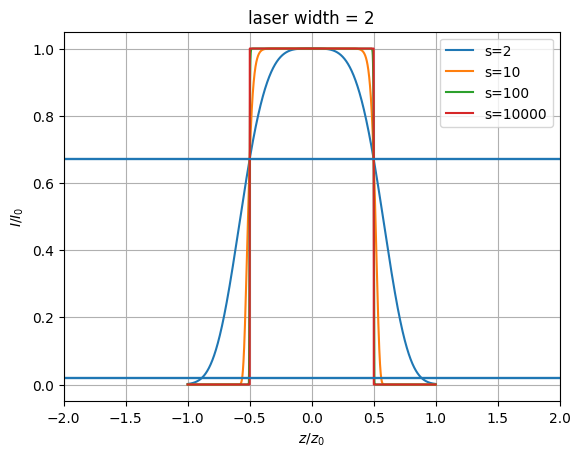

In [3]:
laser_width = 2
iz0 = np.argmin(np.abs(z-laser_width/2))
print(z[iz0]*2)

for s in (2, 10, 100, 10**4):
    laser_intensity = particle_intensity(z=z,
                                         beam_width=laser_width, # laser beam width
                                         s=s, # shape factor
                                         dp=None)
    print(laser_intensity[iz0], np.exp(-1/np.sqrt(2*np.pi)))
    plt.plot(z/laser_width, laser_intensity, label=f's={s}')
    plt.hlines( np.exp(-1/np.sqrt(2*np.pi)), z[0], z[-1])
    plt.hlines( np.exp(-10/np.sqrt(2*np.pi)), z[0], z[-1])
plt.title(f'laser width = {laser_width}')
plt.xlabel('$z/z_0$')
plt.xlim(-2, 2)
plt.ylabel('$I/I_0$')
plt.grid()
plt.legend()